# This notebook tests ANP-RNN + MC Dropout 

Ideally a NP should learn uncertainty, but it may also be overconfident. In neural network monte carlo dropout often provides a more robust uncertainty. Here I compare it and find that the uncertainty from MCLoss improved the validation loss when added to the models estimation of uncertainty.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import sys, re, os, itertools, functools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import optuna
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback
import math

In [3]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("RANP.ipynb")

In [4]:
import torch
from torch import nn
import torch.nn.functional as F

In [5]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from src.plot import plot_from_loader
from src.models.lightning_anp import LatentModelPL
from src.dict_logger import DictLogger
from src.train import main, objective, add_number, run_trial
from src.utils import init_random_seed

In [6]:
# Params
device='cuda'
use_logy=False

# Load kaggle smart meter data

In [7]:
df_train, df_val, df_test = get_smartmeter_df()

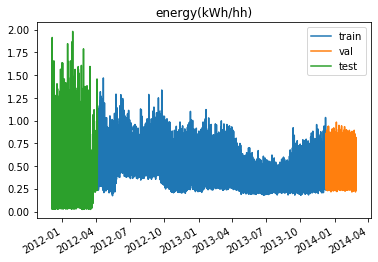

In [8]:
# Show split
df_train['energy(kWh/hh)'].plot(label='train')
df_val['energy(kWh/hh)'].plot(label='val')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Train helpers

In [9]:
PERCENT_TEST_EXAMPLES = 0.5
# EPOCHS = 5
DIR = Path(os.getcwd())
MODEL_DIR = DIR/ 'lightning_logs'
name = 'anp-rnn-mcdropout' # study name
MODEL_DIR.mkdir(parents=True, exist_ok=True)
print(f"now run `tensorboard --logdir {MODEL_DIR}`")

now run `tensorboard --logdir /media/wassname/Storage5/projects2/3ST/attentive-neural-processes/lightning_logs`


In [10]:
from typing import Callable

def convert_layers(model:nn.Module, original:nn.Module, value: bool):
    """
    Turn dropout on
    """
    for child_name, child in model.named_children():
        if isinstance(child, original):
#             print(child, 'from', child.training, 'to', value)
            child.train(value)
            
        else:
            convert_layers(child, original, value)

In [11]:
from src.plot import plot_rows


def eval_mc(model, loader, i):
    device = next(model.parameters()).device

    data = loader.collate_fn([loader.dataset[i]], sample=False)
    data = [d.to(device) for d in data]
    context_x, context_y, target_x_extra, target_y_extra = data
    target_x = target_x_extra
    target_y = target_y_extra

    # do MCDropout estimation
    model.eval()
    convert_layers(model, torch.nn.modules.dropout.Dropout2d, True)
#     model.model._lstm_x.train()
#     model.model._lstm_y.train()

    y_preds = []
    y_stds = []
    with torch.no_grad():
        for i in range(n_mcdropout):
            y_pred, losses, extra = model(context_x, context_y, target_x, target_y)
            y_std = extra['dist'].scale
            y_preds.append(y_pred)
            y_stds.append(y_std)
    y_stds = torch.stack(y_stds)
    y_preds = torch.stack(y_preds)


    mean = y_preds.mean(0)
    sigma = y_stds.mean(0)

    dist = torch.distributions.Normal(mean, sigma)
    log_p = dist.log_prob(target_y).mean(-1)
    loss_mc = - log_p


    # Try without MCDropout
    model.eval()
    with torch.no_grad():
#         y_pred, kl, loss_test, loss_mse, y_std 
        y_pred, losses, extra = model(context_x, context_y, target_x, target_y)
        y_std = extra['dist'].scale
    

    dist = torch.distributions.Normal(y_pred, y_std)
    log_p = dist.log_prob(target_y).mean(-1)
    loss = - log_p   

    return loss_mc.cpu(), loss.cpu()

# Default params

In [12]:
default_params = {
 'attention_dropout': 0,
 'attention_layers': 2,
 'batchnorm': False,
 'det_enc_cross_attn_type': 'multihead',
 'det_enc_self_attn_type': 'uniform',
 'dropout': 0, 
 'hidden_dim': 512,
 'latent_dim': 128,
 'latent_enc_self_attn_type': 'uniform',
 'learning_rate': 0.002, 
 'n_decoder_layers': 4,
 'n_det_encoder_layers': 4,
 'n_latent_encoder_layers': 2, 
 'num_heads': 8, 
 'use_deterministic_path': True,
 'use_lvar': True,
 'use_self_attn': True, 
 'use_rnn': False, 
}
default_attrs = {
    'context_in_target': True,
    'x_dim': 17,
     'y_dim': 1,
    'vis_i': '670',
    'num_workers': 3,
    'num_context': 24*4,
    'num_extra_target': 24*4,
    'max_nb_epochs': 200,
    'min_std': 0.005,
    'grad_clip': 40,
    'batch_size': 16,
    'patience': 2
}

# Train ANP-RNN

# ANP-RNN 2

now run `tensorboard --logdir lightning_logs`
trial.number -25
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
    | Name                                                                      | Type                 | Params
---------------------------------------------------------------------------------------------------------------
0   | model                                                                     | LatentModel          | 24 M  
1   | model.norm_x                                                              | BatchNormSequence    | 34    
2   | model.norm_x.norm                                                         | BatchNorm1d          | 34    
3   | model.norm_y                                                              | BatchNormSequence    | 2     
4   | model.norm_y.norm                                                         | BatchNorm1d          | 2     
5   | model._lstm_x                                                       

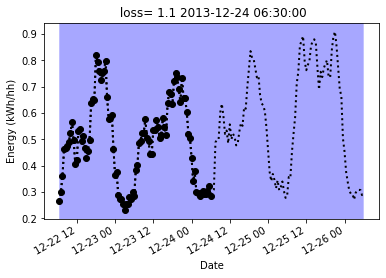

step val 0, {'val_loss': '1.0360383987426758', 'val/kl': '0.49979040026664734', 'val/std': '1.0116103887557983', 'val/mse': '0.26372915506362915'} {}


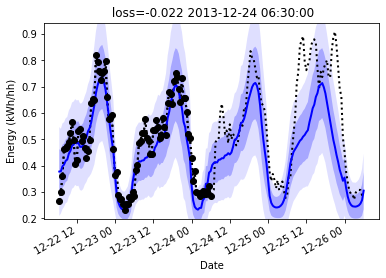

step val 1826, {'val_loss': '-0.45478567481040955', 'val/kl': '0.0014662756584584713', 'val/std': '0.0914391428232193', 'val/mse': '0.009316135197877884'} {'train_loss': -0.3054491877555847, 'train/kl': 0.02520137093961239, 'train/std': 0.15798582136631012, 'train/mse': 0.022584624588489532}
INFO:root:Detected KeyboardInterrupt, attempting graceful shutdown...

Loading checkpoint lightning_logs/anp-rnn-mcdropout/version_-25/_ckpt_epoch_0.ckpt


In [ ]:
n_mcdropout=10
n_steps=600
vis_i=670
results = []

for seed in tqdm([1, 10, 20, 100], desc='seeds'):
    init_random_seed(seed)
    
    trial, trainer, model = run_trial(
        name="anp-rnn-mcdropout",
        params={
         **default_params, 
#          'det_enc_cross_attn_type': 'ptmultihead',
         'latent_enc_self_attn_type': 'ptmultihead',
         'dropout': 0.3,
         'attention_dropout': 0.1,
         'learning_rate': 2e-4, 
         'hidden_dim': 256*2,
         'latent_dim': 256*2, 
         'n_decoder_layers': 4,
         'n_latent_encoder_layers': 4, 
         'num_heads': 8, 
         'use_deterministic_path': False,
         'use_rnn': True,
         'vis_i': 670
        },
        user_attrs = default_attrs,
        PL_MODEL_CLS=LatentModelPL
    )
    
    # MCDropout
    loader = model.val_dataloader()
    device = next(model.parameters()).device
    inds = np.random.randint(0, len(loader.dataset), n_steps)

    losses_mc = []
    losses = []
    for i in tqdm(inds, desc='MCDropout eval'):
        loss_mc, loss = eval_mc(model, loader, i)
        losses_mc.append(loss_mc)
        losses.append(loss)

    loss_mc = torch.stack(losses_mc).mean().item()
    loss = torch.stack(losses).mean().item()
    
    results.append(dict(seed=seed, loss=loss, loss_mc=loss_mc, inds=inds))
    print(f"seed={seed}. Lower is better, validation loss")
    print(f"MCDropout: {loss_mc:2.2f}")
    print(f"Inference: {loss:2.2f}")

In [ ]:
model

In [ ]:
df_result = pd.DataFrame(results)
df_result['loss'] = df_result['loss'].astype(float)
df_result['loss_mc'] = df_result['loss_mc'].astype(float)
print('lower is better')
df_result

# MCDropout test

https://towardsdatascience.com/bayesian-deep-learning-with-fastai-how-not-to-be-uncertain-about-your-uncertainty-6a99d1aa686e

We will apply mcdropout by:
- replacing dropout with a class that will still be on during test
- doing multiple inference

In [ ]:
loader = model.val_dataloader()
dset_test = loader.dataset
label_names = dset_test.label_names
plot_from_loader(loader, model, i=670)

In [ ]:
from src.plot import plot_rows
loader = model.val_dataloader()
device = next(model.parameters()).device

# Get data
i = 670
data = loader.collate_fn([loader.dataset[i]], sample=False)
data = [d.to(device) for d in data]
context_x, context_y, target_x_extra, target_y_extra = data
target_x = target_x_extra
target_y = target_y_extra

# for plotting
x_rows, y_rows = loader.dataset.get_rows(i)
max_num_context = context_x.shape[1]
y_context_rows = y_rows[:max_num_context]
y_target_extra_rows = y_rows[max_num_context:]
x_context_rows = x_rows[:max_num_context]
x_target_extra_rows = x_rows[max_num_context:]
dt = y_target_extra_rows.index[0]
y_target_rows = y_rows

In [ ]:
# do MCDropout estimation
model.eval()
convert_layers(model, torch.nn.modules.dropout.Dropout2d, True)
model.model._lstm_x.train()
model.model._lstm_y.train()

y_preds = []
y_stds = []
with torch.no_grad():
    for i in range(10):
        y_pred, losses, extra = model(context_x, context_y, target_x, target_y)
        y_std = extra['dist'].scale
        y_preds.append(y_pred.cpu().numpy())
        y_stds.append(y_std.cpu().numpy())

y_stds = np.stack(y_stds)
y_preds = np.stack(y_preds)


In [ ]:
# Lets add variation to std, since it it's unsure.. std should be higher. Although this is small
# When it's unsure of the mean, we will also add that, this is large
# This is just a quick and dirty uncalibrated one sure, we could use
y_std = y_stds.mean(0) + y_stds.std(0) + y_preds.std(0)
y_std = y_preds.std(0)
print(f'predicted std {y_stds.mean():2.2f} \nstd of std {y_stds.std(0).mean():2.2f} \nmcdropout of mean {y_preds.std(0).mean():2.2f}')
y_pred = y_preds.mean(0)

In [ ]:
# with 3 sources of uncertainrty: model output and std of mean
y_std = y_stds.mean(0) + y_preds.std(0)
plot_rows(
    x_target_rows=x_target_extra_rows,
    x_context_rows=x_context_rows,
    target_y_rows=y_target_rows,
    context_y_rows=y_context_rows,
    pred_y=y_pred,
    std=y_std,
    legend=False
)
plt.show()

In [ ]:
# Try without MCDropout
model.eval()
with torch.no_grad():
    y_pred, losses, extra = model(context_x, context_y, target_x, target_y)
    y_std = extra['dist'].scale

plot_rows(
    x_target_rows=x_target_extra_rows,
    x_context_rows=x_context_rows,
    target_y_rows=y_target_rows,
    context_y_rows=y_context_rows,
    pred_y=y_pred.detach().cpu().numpy(),
    std=y_std.detach().cpu().numpy(),
    legend=False
)
plt.show()